In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import diffusion_pde as dpde
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Subset

from pathlib import Path

In [2]:
model_path = Path().cwd().parent / "pretrained_models" / "edm_model_heat_equation.pth"
data_path = Path().cwd().parent / "data" / "heat_eq_data_1000_64_64_64_0_20.npz"
model_path.exists(), data_path.exists()

(True, True)

In [3]:
chs = [2, 32, 64, 128, 256]
noise_ch = 32
label_ch = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = dpde.models.Unet(chs=chs, label_ch=label_ch, noise_ch=noise_ch)
edm = dpde.models.EDMWrapper(unet)

edm.to(device)

edm.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [4]:
_, testloader = dpde.datasets.get_dataloaders(
    datapath=data_path,
    batch_size=1,
    test_split=0.2,
    shuffle=True,
    generator=torch.Generator().manual_seed(42),
)

t_steps = testloader.dataset.dataset.t_steps

subset_idxs = testloader.dataset.indices
init_states = testloader.dataset.dataset.init_state[subset_idxs]
data = testloader.dataset.dataset.data[subset_idxs]
labels = testloader.dataset.dataset.labels[subset_idxs]
init_states.shape, data.shape, labels.shape, t_steps.shape

(torch.Size([200, 1, 64, 64]),
 torch.Size([200, 1, 64, 64, 65]),
 torch.Size([200, 1]),
 torch.Size([65]))

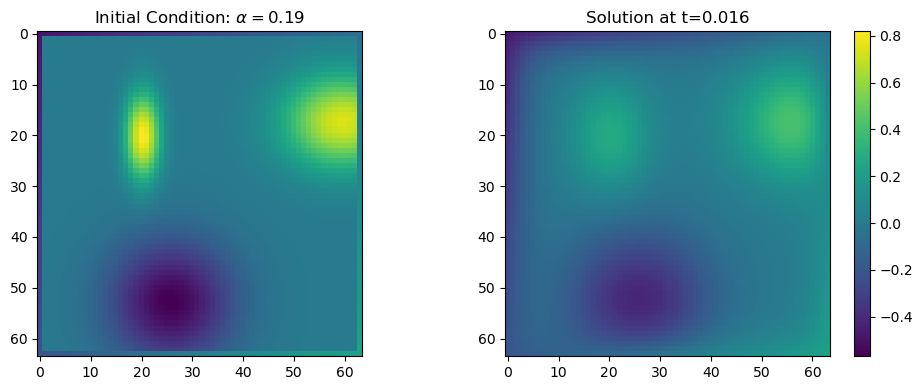

In [5]:
idx = 5     # which sample to visualize
t_idx = 5   # which time step to visualize

T = t_steps[t_idx].item()
alpha = labels[idx, 0].item()

A = init_states[idx].numpy().squeeze()
U = data[idx, ..., t_idx].numpy().squeeze()

vmin, vmax = min(A.min(), U.min()), max(A.max(), U.max())
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
im0 = axs[0].imshow(A, cmap="viridis", vmin=vmin, vmax=vmax)
axs[0].set_title(f"Initial Condition: $\\alpha={alpha:.2f}$")
im1 = axs[1].imshow(U, cmap="viridis", vmin=vmin, vmax=vmax)
axs[1].set_title(f"Solution at t={T:.3f}")
fig.colorbar(im1, ax=axs[1])
plt.tight_layout()
plt.show()

In [7]:
obs_a = torch.tensor(A)
obs_u = torch.tensor(U)
mask_a = torch.ones_like(obs_a)
mask_u = torch.zeros_like(obs_u)
mask_u[0, :] = 1
mask_u[-1, :] = 1
mask_u[:, 0] = 1
mask_u[:, -1] = 1


dx = 1. / A.shape[-1]
ch_a = 1

sample_shape = (32, 2, 64, 64)

zeta_a = 30.0
zeta_u = 5.0
zeta_pde = 0.0

num_steps = 50

t_cond = torch.ones(sample_shape[0]) * T
alpha_cond = torch.ones_like(t_cond) * alpha
labels = torch.stack([t_cond, alpha_cond], dim=-1)


samples, losses = dpde.sampling.edm_sampler(
    net=edm,
    device=device,
    sample_shape=sample_shape,
    loss_fn=dpde.sampling.heat_loss,
    dx=dx,
    ch_a=ch_a,
    labels=labels,
    obs_a=obs_a,
    obs_u=obs_u,
    mask_a=mask_a,
    mask_u=mask_u,
    zeta_a=zeta_a,
    zeta_u=zeta_u,
    zeta_pde=zeta_pde,
    num_steps=num_steps,
    debug=True,
)

dxdt shape: torch.Size([32, 2, 64, 64])


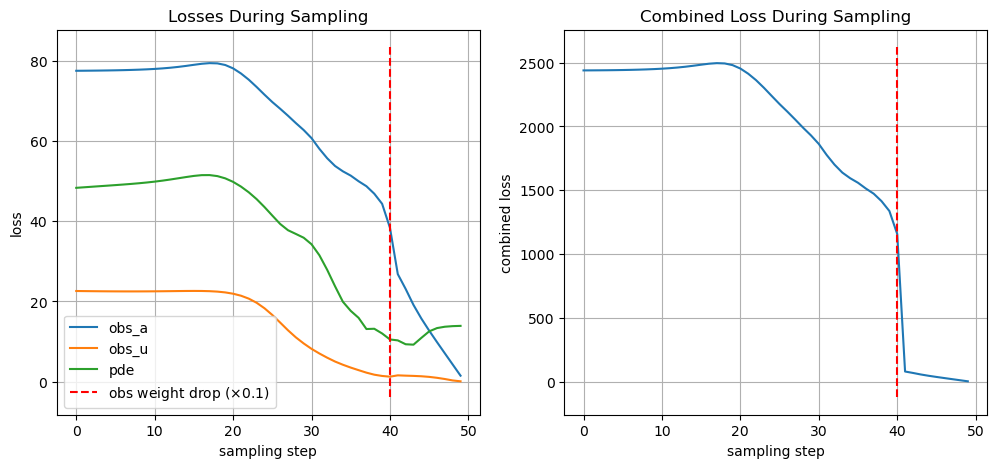

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses[:, :3])
axs[0].set(xlabel='sampling step', ylabel='loss', title="Losses During Sampling")
axs[0].grid()
axs[1].plot(losses[:, 3])
axs[1].set(xlabel='sampling step', ylabel='combined loss', title="Combined Loss During Sampling")
axs[1].grid()
for i in range(2):
    temp_min, temp_max = axs[i].get_ylim()
    axs[i].vlines(0.8 * num_steps, ymin=temp_min, ymax=temp_max, color='red', linestyle='--')
axs[0].legend(['obs_a', 'obs_u', 'pde', 'obs weight drop ($\\times 0.1$)'])
plt.show()

RMSE Initial Condition: 0.3324
RMSE Solution at t=0.016: 0.0982


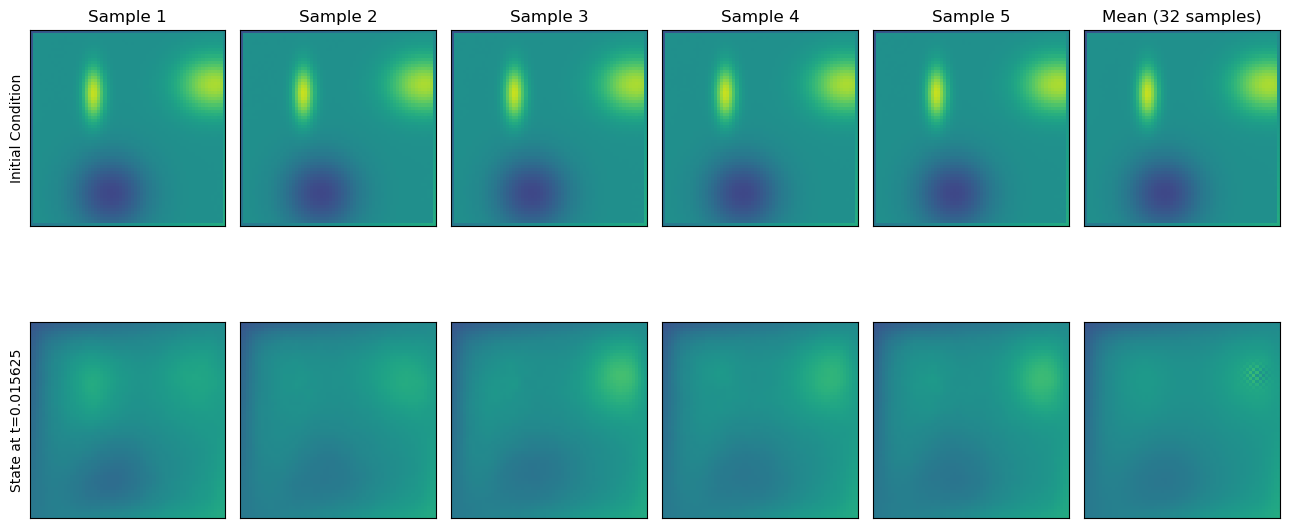

In [33]:
mean_val = samples.mean(axis=0)

print(f"RMSE Initial Condition: {np.sqrt(np.mean((samples[:, 0] - obs_a[0].numpy())**2)):.4f}")
print(f"RMSE Solution at t={T:.3f}: {np.sqrt(np.mean((samples[:, 1] - obs_u.numpy())**2)):.4f}")

fig, axs = plt.subplots(2, 6, figsize=(13, 7))
for i in range(5):
    axs[0, i].imshow(samples[i, 0], cmap='viridis', vmin=-1, vmax=1)
    axs[0, i].set(aspect="equal", xticks=[], yticks=[])
    axs[0, i].set_title(f'Sample {i+1}')
    if i == 0:
        axs[0, i].set_ylabel('Initial Condition')
    axs[1, i].imshow(samples[i, 1], cmap='viridis', vmin=-1, vmax=1)
    axs[1, i].set(aspect="equal", xticks=[], yticks=[])
    if i == 0:
        axs[1, i].set_ylabel(f'State at t={T}')
    
axs[0, 5].imshow(mean_val[0], cmap='viridis', vmin=-1, vmax=1)
axs[0, 5].set(aspect="equal", xticks=[], yticks=[], title=f"Mean ({sample_shape[0]} samples)")
axs[1, 5].imshow(mean_val[1], cmap='viridis', vmin=-1, vmax=1)
axs[1, 5].set(aspect="equal", xticks=[], yticks=[])
plt.tight_layout()